# Amazon Products Collaborative Filtering Recommender System
## Contents
* Data Understanding
* Exploratory Data Analysis
* Data Preprocessing
* Modeling
* Building Recommender System

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy.sparse import coo_matrix
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
sns.set(font_scale=1.4)

Loading Dataset

In [2]:
data = pd.read_csv('ratings_Beauty.csv')

## Data Understanding

In [3]:
data.head()

,UserId,ProductId,Rating,Timestamp
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200
3,A1WMRR494NWEWV,0733001998,4.0,1382572800
4,A3IAAVS479H7M7,0737104473,1.0,1274227200


In [4]:
data.shape

(2023070, 4)

In [5]:
info = pd.DataFrame(index=data.columns, columns=['Dtype', 'Unique Numbers'])
info['Dtype'] = data.dtypes
info['Null values'] = data.isna().sum()
info['Unique Numbers'] = data.nunique()
info['Description'] = ['Customer Identification', 'Product Identification', 'Rating', 'Time']
info

,Dtype,Unique Numbers,Null values,Description
UserId,object,1210271,0,Customer Identification
ProductId,object,249274,0,Product Identification
Rating,float64,5,0,Rating
Timestamp,int64,4231,0,Time


In [6]:
info['Dtype'].value_counts()

object     2
float64    1
int64      1
Name: Dtype, dtype: int64

In [7]:
print('Duplicated Values:', data.duplicated().sum())

Duplicated Values: 0


In [8]:
print('Null Values:', data.isna().sum().sum())

Null Values: 0


In [9]:
df = data.copy()

## Exploratory Data Analysis
### Univariate
* Numerical features
* Categorical features


### Bivariate
* Rating analysis

**Univariate**

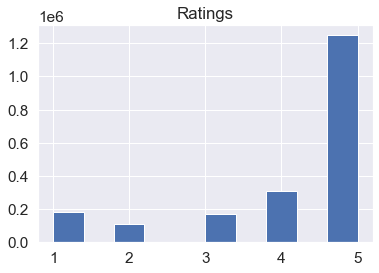

In [10]:
df['Rating'].hist()
plt.title('Ratings')
plt.show()

Unique users

In [11]:
print('Unique Users Percentage:', df['UserId'].nunique() / len(df) * 100)

Unique Users Percentage: 59.82348608797521


Unique products

In [12]:
print('Unique Products Percentage:', df['ProductId'].nunique() / len(df) * 100)

Unique Products Percentage: 12.321570682181042


**Bivariate**

In [13]:
products_ratings = df.pivot_table(index='ProductId',
                                  columns='Rating', values='Timestamp',
                                  aggfunc='count', fill_value=0)
products_ratings.columns = ['Rating ' + str(col) for col in products_ratings.columns]
products_ratings['Frequency'] = products_ratings.sum(axis=1)

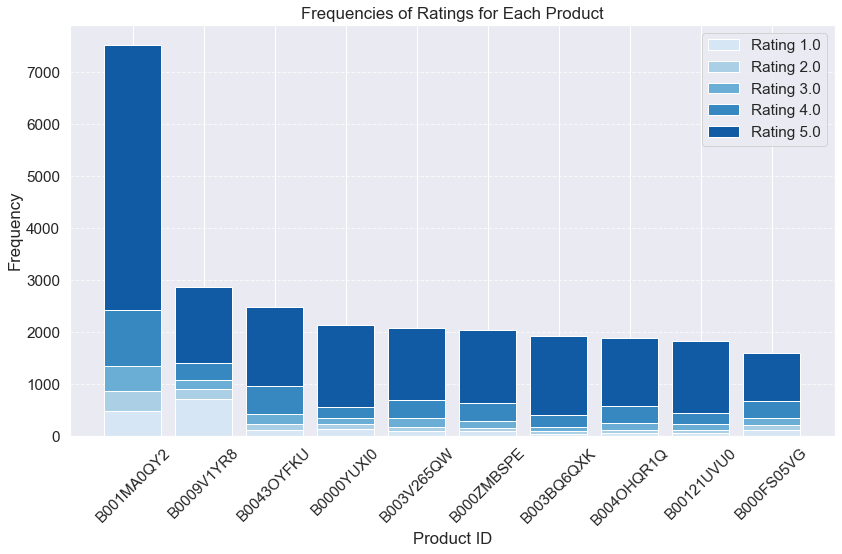

In [14]:
df = products_ratings.sort_values('Frequency', ascending=False).head(10)
ratings = df[['Rating 1.0', 'Rating 2.0', 'Rating 3.0', 'Rating 4.0', 'Rating 5.0']].values
product_ids = df.index.values
colors = sns.color_palette('Blues', n_colors=5)
plt.figure(figsize=(12, 8), facecolor='w')
for i in range(5):
    plt.bar(product_ids, ratings[:, i], bottom=ratings[:, :i].sum(axis=1),
            color=colors[i], label='Rating ' + str(i+1) + '.0')

plt.xlabel('Product ID')
plt.ylabel('Frequency')
plt.title('Frequencies of Ratings for Each Product')
plt.legend(loc='upper right')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Data Preprocessing
* Encoding
* Columns removal

In [15]:
data.drop('Timestamp', axis=1, inplace=True)

Change IDs both for users and products with incremental numbers which is easy to deal with

In [16]:
user_ids = data['UserId'].unique()
user_id_map = {old_id: new_id for new_id, old_id in enumerate(user_ids)}
data['UserId'] = data['UserId'].map(user_id_map)

In [17]:
product_ids = data['ProductId'].unique()
product_id_map = {old_id: new_id for new_id, old_id in enumerate(product_ids)}
data['ProductId'] = data['ProductId'].map(product_id_map)

In [18]:
data.head()

,UserId,ProductId,Rating
0,0,0,5.0
1,1,1,3.0
2,2,1,5.0
3,3,2,4.0
4,4,3,1.0


## Modeling
* Collaborative filtering modeling

Creating user-item metrix with a sample of data

In [19]:
user_item_matrix = data.head(10000).pivot_table(values='Rating', index='UserId', columns='ProductId', fill_value=0)

In [20]:
user_item_matrix.shape

(9697, 886)

Reducing dimension using SVD

In [21]:
X = user_item_matrix.T
X1 = X
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)

In [22]:
decomposed_matrix.shape

(886, 10)

Calculating correlation matrix

In [23]:
correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(886, 886)

## Building Recommender System

Let's see how does it work

In [24]:
def recommend(user_id, product_id):
    indices = list(X.index)
    product_idx = indices.index(product_id)
    user_idx = indices.index(user_id)
    correlation_user_ID = correlation_matrix[product_idx]
    Recommend = list(X.index[correlation_user_ID > 0.5])
    return Recommend[1:6]

In [25]:
recommend(user_id=23, product_id=3)

[17, 21, 25, 26, 29]

So we input the user and the product he has purchased and the output is top 5 closest recommended items according to others purchases